<h1><center>Artificial Neural Networks II</center></h1>

<br>
<br>
<center><font size="3">This notebook is a part of teaching material for CS-EJ3311 - Deep Learning with Python</font></center>
<center><font size="3">23.10.2023-10.12.2023</font></center>
<center><font size="3">Aalto University & FiTech.io</font></center>

<img src="https://blog.keras.io/img/keras-tensorflow-logo.jpg" width=400>

<h2><center>The Python Deep Learning Library Keras</center> </h2>

Let us now introduce some basic functions provided by the Python package (library) Keras. Technically, Keras is a high-level API for the low-level deep learning Python library [`TensorFlow`](https://www.tensorflow.org/overview/). It has been created for a quick and easy model design and training. 
The typical workflow of constructing and training an ANN using Keras is as follows:
 
 1. define the training and validation (test) data†
 2. define the ANN structure (sequence of layers, number of neurons in each layer, activation functions)
 3. choose a loss function, optimizer (gradient-based iterative algorithm), and some metric to monitor the learning process
 4. tune the weights of the ANN by using the `.fit()` method
 
†Here we call the data subset used for a model validation during hyperparameter tuning **validation set**.  The data subset used for a final model validation is called **test set**. 
 
We start with importing the Python libraries:

In [55]:
import matplotlib.pyplot as plt     # tools for plotting data 
import numpy as np                  # numerical computations (vectors, matrices, tensors)
import pandas as pd                 # handling tabular data (tables)
import tensorflow as tf             # deep learning library 
from tensorflow import keras        # deep learning library 
from tensorflow.keras import layers # Keras ANN layers 

# disable info messages from tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

# for reproducibility 
np.random.seed(1)
tf.random.set_seed(1)

from utils import load_styles

# This MUST be the last line of this cell
load_styles()

In [56]:
# set trainig = False when validating or submitting notebook
# and set training = True, when training network
training=True

In [92]:
# this is a hidden cell to set training=False


### Step 1 - Loading Data

We will use the [Fashion-MNIST ](https://keras.io/api/datasets/fashion_mnist/) dataset which is provided within [keras datasets](https://keras.io/api/datasets/). This dataset consists of data points representing articles of an online shop. Each article is characterized by a $28 \times 28$ pixels grayscale image. Moreover, each article is associated with a label $y$ that indicates to which of $10$ classes (or product categories) this article belongs. 

When you load `fashion_mnist` dataset with `fashion_mnist.load_data()`, the loading function automatically returns data split (as NumPy arrays) on training and test sets. The entire training dataset consists of $60000$ data points and **you would need to split the training set further into the training and validation set** by yourself. The test set is of size $10000$ data points. 

The $10000$ data points in the test set **must not be used** for learning the ANN weights and also not for monitoring the progress (validation) of the gradient method. Indeed, the monitoring of the validation error is some form of model adjustment as we use the validation error to decide when to stop the gradient method.  

In [ ]:
import ssl
# need this line (certificate verification) for loading dataset
ssl._create_default_https_context = ssl._create_unverified_context

# load dataset
from tensorflow.keras.datasets import fashion_mnist
(trainval_images, trainval_labels), (test_images, test_labels) = fashion_mnist.load_data()

# shape of train and test image
print(f'\nNumber of training and validation examples {trainval_images.shape}')
print(f'\nNumber of test examples {test_images.shape}')

As you can see, the data is stored as 3D NumPy arrays, where the first dimension is the number of samples and the last two - the size of the image (28x28 pixels). Let's find out the range of feature values (pixels) and data type:

In [ ]:
print(f'Min feature value {trainval_images.min()}')
print(f'Max feature value {trainval_images.max()}')
print(f'Data type {type(trainval_images.min())}')

The data point labels are integer values between 0 and 9:

In [ ]:
# the label values are stored as integer numbers, in the range [0, 9]
# these numeric labels correspond to the classes of clothing items the image represent:

labels = np.unique(test_labels)
print(labels)

The code snippet below maps the numeric label values to class names. The class names are defined according to [documentation](https://www.tensorflow.org/tutorials/keras/classification).

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

# display numeric label and corresponding class name 
print('label value \t category \n')
for class_name, label in zip(class_names, labels):
    print (f'{label} \t\t {class_name}')

Let's visualize a few data points (images):

In [ ]:
# visuale 10 first images from test set
plt.figure(figsize=(10,10))
i = 0
for (image, label) in zip(test_images[:10],test_labels[:10]):
    plt.subplot(5,5,i+1)
    plt.xticks([]) # remove ticks on x-axis
    plt.yticks([]) # remove ticks on y-axis
    plt.imshow(image, cmap='binary') # set the colormap to 'binary' 
    plt.xlabel(class_names[label])
    i += 1
plt.tight_layout()    
plt.show()

Each shop item is characterized by a feature vector $\mathbf{x}=\big(x_{1},\ldots,x_{n}\big)$ of length $n = 784$ which corresponds to $28 \times 28$ pixels. The feature $x_{i}$ is the grayscale values of $i$th pixels. A black pixel has grayscale value 0, while a white pixel has grayscale value $255$. 

The code snippet below reads in one data point (shop item) and illustrates its features, i.e., grayscale values of each pixel. 

In [ ]:
# select the image to visualize
img = test_images[0]
# create figure and axis objects
fig, ax = plt.subplots(1,1,figsize = (8,8)) 
# display image
ax.imshow(img, cmap='gray')
width, height = img.shape
# this value will be needed in order to change the color of annotations
thresh = img.max()/2.5

# display grayscale value of each pixel
for x in range(width):
    for y in range(height):
        val = (img[x][y])
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    # if a pixel is black set the color of annotation as white
                    color='white' if img[x][y]<thresh else 'black')
plt.show()

Before we proceed to build and train the model, we will preprocess the data. First, let's choose only a subset for training data in order to reduce training time:

In [ ]:
# select subset of trainval_images and trainval_labels (to reduce training time)
X_trainval = trainval_images[:16000]
y_trainval = trainval_labels[:16000]

# select whole test set
X_test = test_images
y_test = test_labels

Next, we need to reshape feature matrices `X_trainval` and `X_test` into the shape our model expects.\
The first layer of our ANN is the input layer with a dimensionality of 784 (28x28 pixel values/features per data point). Thus, we need to reshape the feature matrices `X_trainval` and `X_test` from  (-1, 28, 28) to (-1, 784):


In [ ]:
# reshape data from (m, 28, 28) to (m, 784)
X_trainval = X_trainval.reshape(-1, 28 * 28)
X_test = test_images.reshape(-1, 28 * 28)

We refer to this stacking of a two-dimensional array of pixel grayscale values into a one-dimensional vector $\mathbf{x}$ as **flattening**. 

When training the ANN it is a good practice to normalize the input values so that they are between 0 and 1, in our case, the pixel values.

Let's transform feature values of type uint8 in a range [0, 255] to feature values of type float in the range [0, 1]:

In [ ]:
# normalize data to have feature values between 0 and 1
X_trainval = X_trainval/ 255.0
X_test = X_test/ 255.0

### Step 2. Define Hypothesis Space - ANN Structure

To classify the shop items into 10 categories we learn a predictor map represented by an ANN. The ANN reads in the features $x_{i}$ of a shop item, which are the grayscale values of the item image. The output of the ANN are probabilities, or degrees of belonging, for each of the ten different categories. 

In particular, we will use an ANN with an arbitrary architecture:

- input layer 
- one dense layer with 128 units and ReLU activation function
- output layer with 10 units and softmax activation function

The input layer consists of the individual features and is the entry point to the ANN. The input layer is connected to a dense layer with 128 neurons with the ReLU activation function. This hidden layer is then followed by the final output layer with ten neurons and a softmax activation function. 

The output layer with 10 neurons (corresponding to 10 classes) returns probabilities of belonging to a certain class. Note, that output values of all 10 neurons always sum to one. This is the result of using the softmax activation function in the last layer. For example, if the output of a first neuron (out of 10) is close to 1, we are confident in assigning the data point to class $1$. 

There are three main ways to build ANN in tensorflow backend Keras. The easiest one is to use [keras.Sequential() class](https://keras.io/api/models/sequential/). This class is used when you just need to stack layers sequentially. In contrast, [Functional API](https://keras.io/guides/functional_api/) is more flexible and allows building models with non-sequentional structure, multiple inputs and outputs. Finally, for more advanced users Keras provides [Dynamic models with Subclussing API](https://keras.io/guides/making_new_layers_and_models_via_subclassing/).

Here we will use a simple Sequential model. Below you will see 3 variations of how to build a Sequential model:

In [ ]:
# method 1
# create an object - 'model' that represents an ANN
model = keras.Sequential()      
# add layers by using `model.add()` method
model.add(layers.InputLayer(input_shape=(784,)))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

# method 2
# make a list of layers and pass to `keras.Sequential()`
model = keras.Sequential([
    layers.InputLayer(input_shape=(784,)),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

# method 3
# skip input layer and indicate input shape in the first hidden layer instead
model = keras.Sequential([
    layers.Dense(units=128, activation='relu', input_shape=(784,)),
    layers.Dense(units=10, activation='softmax')
])

The last variant seems to be cleaner, so let's use it to define the model:

In [ ]:
# define model architecture

model = keras.Sequential([
    # hidden layer
    layers.Dense(128, activation='relu',input_shape=(784,)),
    # output layer
    layers.Dense(10, activation='softmax')
])

We can call the `summary()` method on the model to see information about it. This method provides the following textual information:
- The number of parameters (weights) in each layer
- The total number of parameters (weights) in the model
- The layers and their order in the model
- The output shape of each layer

In [ ]:
model.summary()

The above summary indicates that the ANN has a total of $d=101,770$ parameters (weights and biases) that can be adjusted (trained) based on labeled training data. You can also compute the number of parameters manually: 
- number of parameters in hidden layer 784*128+128 = 100480
- number of parameters in output layer 128*10+10 = 1290

or generally, the number of parameters in a layer equals to (n.o. neurons in previous layer)*(n.o. neurons in current layer) + (n.o. neurons in current layer). The last term corresponds to the biases of each neuron.

The basic theory of ML suggests that we would need at least the same number of training examples to reliably train the ANN weights. A (crude!) rule of thumb is to have ten times more training data points than learnable weights. This would amount to a training set of around one million data points for which we would need to know the correct labels. Obviously, we have a much smaller dataset, but let's see how our model performs in practice.

The textual model summary above is useful for simple models. However, this textual summary can be difficult to interpret for ANN structures with multiple inputs or outputs. To this end, `tf.keras` provides a function called `plot_model()` to create a graphical summary of the ANN that might be easier to understand.

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes=True, 
    show_layer_names=True
)

### Step 3 - Choose Loss Function and Optimizer

Before we can start the training of the ANN, i.e., the tuning of the ANN weights, we need to define:

- the specific algorithm, optimizer, (usually variant of gradient descent) for tuning the weights of the ANN
- the loss function used to measure the quality of particular choice for the weights
- the metric to assess the performance of the final choice for the weights. 

The code snippet below illustrates how to choose the categorical cross-entropy as loss function, the accuracy (fraction of correctly classified data points) as the metric, and the "RMSprop" variant of GD. All these parameters are specified using the Keras function `compile()`. 

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Info</b><br>
     <p style="color: black">
In Keras we use <code>categorical_crossentropy</code> loss function for multiclass classification & when labels are provided in one-hot representation. We use <code>sparse_categorical_crossentropy</code> when you want to provide labels as integers. What are the differences? In principle none, as they both compute categorical cross-entropy, but read more <a href="https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c">here</a>. <br>
<br>
For classification problems we will use accuracy metrics <code>metrics='sparse_categorical_accuracy'</code>, but <a href="https://keras.io/api/metrics/">other metrics</a> are also provided by Keras.    
</p>
    
</div>

In [ ]:
# compile the model
model.compile(optimizer='RMSprop',
              loss='sparse_categorical_crossentropy',
              metrics='sparse_categorical_accuracy')

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Info</b><br>
    <p style="color: black">
        With statement: </p>

```python
>>> model.compile(optimizer='RMSprop', ... )
```
    
<p style="color: black">
we choose the optimizer RMSprop with <a href="https://keras.io/api/optimizers/rmsprop/">default parameters</a>. 
To print out the default learning rate use:</p>  
    
```python
>>> model.optimizer.learning_rate
>>> <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>
```
    
</div>

### Step 4. Training - Adjusting ANN Weights

We are now ready to train our network, which is done via a call to the `.fit()` method. Any Keras object that represents an ANN also provides a `.fit()` method which optimizes the ANN weights. 

Before we run following line of code, let's understand parameters in `.fit()` function: `validation_split`, `batch_size` and `epochs`. 

- **validation_spit:** `validation_split` is used to separate a portion of our training data into a validation dataset and evaluate the performance of our model on that validation dataset for each epoch. We can specify the percentage we want to allocate to the validation set by setting this `validation_split` argument in the `.fit()` function to a percentage of the size of our training dataset.

     So, why do we need a validation set anyway? A validation set is used to estimate the performance of a model for a given 
     training run (epoch). Meaning we will use the training set to train the model and use the validation set (data that's not 
     seen by the model during training) to predict while the model is being trained.  This will help us to get insight into 
     whether our model is overfitting or not. We can find out if the model is overfitting or not by comparing the accuracy and 
     loss from our training samples to the validation accuracy and validation loss from our validation samples. Further, we can 
     also use these accuracy measures from these two different sets to tune the hyper-parameters (like learning rate, number of 
     epochs the model should be trained) of the model.
     <br>

- **batch_size**: Number of samples per gradient update. If unspecified, `batch_size` will default to 32. Do not specify the `batch_size` if your data is in the form of tensorflow datasets, generators, or keras.utils. sequence instances (since they are already generating batches of a certain size).
<br>

- **epochs**: This parameter is the number of times we want the optimization algorithm to use the entire dataset for tuning the weights. In general, the training loss decreases with increasing the number of epochs. 


In [ ]:
%%time 
# track execution time

if training==True:
    history = model.fit(X_trainval, y_trainval, validation_split=0.2, batch_size=32, epochs=20, verbose=1)

### Read the Training Log !
 

`model.fit()` method has a parameter `verbose`, which is set to `verbose=1` [by default](https://keras.io/api/models/model_training_apis/#fit-method). This parameter controls information printed out during training. In the beginning, you see information about epoch number and progress bar is printed:

`Epoch 1/20`\
`[==>...........................]`

In addition, the total elapsed time and the time per sample is also printed for each epoch:

`Epoch 1/20`\
`400/400 [==============================] - 1s 3ms/step`

400 is a number of batches per epoch: 16000*0.8/32

And most importantly, you can track loss values and values of metrics (e.g. accuracy):

`loss: 0.6978 - accuracy: 0.7581 - val_loss: 0.5176 - val_accuracy: 0.8094`

Note, that training loss and training accuracy are running averages - their values are updated after processing each batch. Loss and accuracy on the validation set are evaluated only at the end of an epoch. 

If you will set `verbose=2`, the progress bar and time elapsed will not be printed out and `verbose=0` is a silent mode. 

### Plot Training History 

A `.fit()` method not only determines a good choice for the weights but also returns a history object. The history object contains different metrics for each epoch of the training (optimization) process. 

The metrics recorded during the training process are stored as a dictionary in the `.history` attribute of the `history` object. To get a better understanding of how well the training process went, it is useful to plot the metrics as a function of epoch number. In particular, these plots allow analyzing:

- how fast the optimization algorithm improves the loss function by adjusting the weights
- whether there is any significant progress made anymore
- whether the resulting predictor is overfitting (validation loss much higher than training loss) 

Note! While training loss/accuracy is computed as a running average, which is updated after computing loss for the current batch, validation loss/accuracy is computed at the end of the epoch. This means that validation loss/accuracy values sometimes will look better than for the training set, but only because they were computed after multiple parameters' updates.

In [ ]:
import pandas as pd    # library for handling tabular data

# plot training log
if training:
    pd.DataFrame(history.history).plot(figsize=(7,4))
    plt.grid(True)
    plt.xlabel('epoch', fontsize=14)
    plt.show()

We can see from the plot that the model is overfitting: training loss is much lower than validation loss, while training accuracy is higher than accuracy on the validation dataset (~0.92 vs ~0.86).

### Evaluation on Test Set

After completing the training of ANN, we should evaluate the performance of the ANN with the final weights. For this, we will use a set of labeled data points that is different from the training and the validation sets. Indeed, we use the training set to train (optimize/tune/adjust) the ANN weights and we also use the validation set to choose hyperparameters, e.g. decide when to stop training (see [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) for more info). Thus, both, the training set and validation set are used to find the final ANN weights. Therefore we need a test set that is different from the training and the validation sets. 

Let's evaluate the accuracy of our model on the test set with the `.evaluate()` function.


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Accuracy on test dataset: {test_accuracy:.2f}')

We can see that the accuracy on the test dataset is similar to the accuracy on the validation dataset (~0.86).

<a id='1.4'></a>
<div class=" alert alert-success">
    <h3><b>Student task 1.4.</b> ANN for regression problem.</h3>

[Points: 1.5p]

Now, as you are familiar with basic tools to work with a neural network, your task is to build and train ANN similar to described above, but for a regression problem. We will use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn-datasets-fetch-california-housing) from sklearn. 
    
- ANN for regression should predict real numbers (not restricted to range 0-1 as in the case with predicting probabilities). 
- You can freely choose the architecture of ANN (number of layers, neurons) and training parameters (validation_split, batch_size, epochs). 
    
- We advice to use ReLU activation function for neurons in hidden layer(s).
    
You should think about:
    
- What loss function is used for the prediction of continuous numeric value? 
- Do you need to apply the activation function to the output neuron? 
    
</div>
    
<div class=" alert alert-danger">
    <h3 align='center'><b>Evaluate your model on a test set and achieve test loss (MSE) $\leq$ 0.42.</b></h3>
</div>

<br>
</div>

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Info</b><br>
    <p style="color: black">
        You do not need to specify metrics in <code>model.compile()</code>, if loss and metrics are the same. For example:
    </p>

    
```python
>>> model.compile(optimizer='RMSprop', loss='mean_squared_error')
```

<p style="color: black">Here both, the loss and the metrics, are mean squared error (MSE).</p>
    
</div>

<a id='2.4'></a>
<div class=" alert alert-danger">
    <h3 align='center'><b> Save your model !</b></h3>
    
<p>Save your model for later grading:</p>
    
- Save whole model (configuration + weights) with the  `model_reg.save("model_reg.h5")` function 
- Trained model can be loaded with the `tf.keras.models.load_model("model_reg.h5")` function 
- More about saving model <a href="https://keras.io/getting_started/faq/#what-are-my-options-for-saving-models">in Keras FAQ</a>
    
</div>

In [57]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# function to load dataset
def load_dataset():
    
    X, y = fetch_california_housing(return_X_y=True)
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # scale feature values
    scaler = StandardScaler()
    X_trainval = scaler.fit_transform(X_trainval)
    X_test = scaler.transform(X_test)
    
    return X_trainval, y_trainval, X_test, y_test

In [58]:
#========== Step 1. Loading Data ==========#

X_reg_trainval, y_reg_trainval, X_reg_test, y_reg_test = load_dataset()

# shape of train and test image
print(f'Shape of  X_reg_trainval {X_reg_trainval.shape}')
print(f'Shape of  X_reg_test {X_reg_test.shape}')

Shape of  X_reg_trainval (16512, 8)
Shape of  X_reg_test (4128, 8)


In [59]:
#========== Step 2. Define Hypothesis Space - ANN Structure ==========#

# YOUR CODE HERE
model_reg = keras.Sequential([
    # hidden layer
    layers.Dense(128, activation='relu',input_shape=(X_reg_trainval.shape[1],)),
    # output layer
    layers.Dense(1)
])

# Start from smaller model (e.g. one hidden layer) and add more layers/ neurons if needed
# model_reg = ...

In [60]:
# this cell is for tests


In [61]:
# this cell is for tests


In [62]:
# this cell is for tests


In [63]:
#========== Step 3 - Choose Loss Function (MSE) and Optimizer (choose from Keras optimizers) ==========#

# YOUR CODE HERE
model_reg.compile(optimizer='RMSprop',
              loss='mean_squared_error')


In [64]:
# this cell is for tests


Write the rest of the code (training and model saving steps) inside if-loop. With 

```python
if training:
    history = ...
    model_reg.save(...)
else: 
    model_reg = tf.keras.models.load_model("model_reg.h5")
```

teachers can change the flag to `training==False` and skip the training part during automated grading, loading the saved model instead.

Note, that 

`if training:` is equivalent to `if training==True:`.

In [65]:
#========== Step 4. Training - Adjusting ANN Weights ==========#
training = True
if training:

    history = model_reg.fit(X_reg_trainval, y_reg_trainval, validation_split=0.2, batch_size=128, epochs=30, verbose=1)
    model_reg.save('model_reg.h5')
    
else: 
    model_reg = tf.keras.models.load_model("model_reg.h5")

Epoch 1/30
104/104 [==============================] - 0s 2ms/step - loss: 1.8120 - val_loss: 0.7082
Epoch 2/30
104/104 [==============================] - 0s 1ms/step - loss: 0.5810 - val_loss: 0.5172
Epoch 3/30
104/104 [==============================] - 0s 1ms/step - loss: 0.4565 - val_loss: 0.4715
Epoch 4/30
104/104 [==============================] - 0s 1ms/step - loss: 0.4376 - val_loss: 0.4440
Epoch 5/30
104/104 [==============================] - 0s 1ms/step - loss: 0.4029 - val_loss: 0.4271
Epoch 6/30
104/104 [==============================] - 0s 1ms/step - loss: 0.3948 - val_loss: 0.4180
Epoch 7/30
104/104 [==============================] - 0s 1ms/step - loss: 0.3791 - val_loss: 0.4255
Epoch 8/30
104/104 [==============================] - 0s 1ms/step - loss: 0.3730 - val_loss: 0.4054
Epoch 9/30
104/104 [==============================] - 0s 1ms/step - loss: 0.3664 - val_loss: 0.3946
Epoch 10/30
104/104 [==============================] - 0s 1ms/step - loss: 0.3652 - val_loss: 0.3918

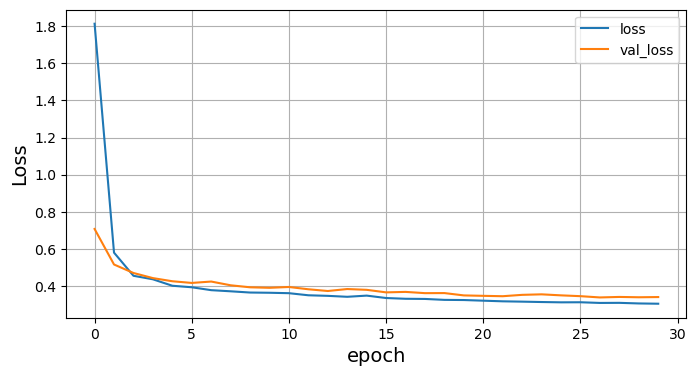

In [66]:
# plot training log
if training:
    pd.DataFrame(history.history).plot(figsize=(8,4))
    plt.grid(True)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.show()

In [67]:
# loss on test set

test_loss = model_reg.evaluate(X_reg_test,y_reg_test, batch_size=128, verbose=0)
print(f'MSE loss on test dataset: {test_loss: .2f}')

MSE loss on test dataset:  0.33


In [69]:
# Sanity check

assert test_loss <= 0.42, "MSE loss is too large!"

In [70]:
# this cell is for tests


<div class=" alert alert-success">
    <h3><b>Try it out. </b>Designed features.</h3>

Although the main idea of deep learning is to move away from hand-crafted features to a data-driven approach, sometimes "creating" and adding more features helps to train ANNs.
    
Go to TensorFlow playground https://playground.tensorflow.org/ . Use the following parameters:

- dataset - Spiral
- features ${X}_{1}$ and ${X}_{2}$
- 2 hidden layers with 6 units each, coupled with ReLU
- learning rate 0.01
    
Train for about ~500 epochs. Take a close look at the train and test loss values.
    
Now, add the rest of the features. Try training again and notice the difference.
</div>

## Model parameters and hyperparameters

We call weights and biases **parameters** of a model. We can find optimal parameters by feeding data to a certain algorithm, e.g. gradient descent. In other words, parameters can be inferred from the data we have. In contrast, there are **hyperparameters** of a model, which cannot be inferred from data. Some examples of hyperparameters are:

- number of layers in ANN
- number of units (neurons) in a layer
- activation function
- learning rate
- batch size
- number of epochs
- optimizer 

Read this [blog post](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/) if still unsure about difference between parameters and hyperparameters.

It is quite difficult to estimate in advance which hyperparameters to use and usually one has to try it out experimentally. Nevertheless, there is some progress in this topic and it is an active area of research. For example, autoML (automated machine learning) solutions are already offered by major tech companies. 

You can try out Python sklearn autoML solution:
- https://automl.github.io/auto-sklearn/master/
- https://machinelearningmastery.com/auto-sklearn-for-automated-machine-learning-in-python/

In practice, ANN with one or two hidden layers and about a hundred neurons per layer is enough for many cases. In more difficult problems making a deeper network might be beneficial. One simple approach would be to build a model which will overfit data and then add regularization (we will discuss such methods in the later notebooks).

Quick reminder: we say that model overfits data, when it performs very well on a training set, but much worse on a validation set. Adding regularization usually improves models' performance on a validation set. 

The number of neurons in input and output layers depends on input and output dimensions. Previously we build ANN for the image classification task with 784 neurons in the input layer (corresponds to input image of size 28x28 pixels) and 10  - in the output layer (corresponds to 10 classes). As for hidden layers, the number of neurons can be the same in each layer. Some architectures (e.g. autoencoders) have more neurons in the first and last layers and fewer neurons in the middle, thus creating a "bottleneck". Unless it is made on purpose, creating a bottleneck is not advised as it may lead to the loss of some information. 

<a id='1.5'></a>
<div class=" alert alert-success">
    <h3><b>Student task 1.5.</b> Hyperparameter tuning - Number of hidden layers.</h3>

[Points: 2+2p]
    
Consider two ANN structures that have the same total number of hidden units but a different number of layers. In this task you compare the performance of these two models on **Fashion-MNIST classification dataset**.
    
The first model should consist of:
    
- one hidden layer with 256 units and ReLU activation
- one output layer with 10 units and softmax activation function
    
    
The second model should consist of:
    
- 4 hidden layers with 64 units and ReLU activations
- one output layer with 10 units and softmax activation function

Use loss - `sparse_categorical_crossentropy` and  metrics -  `sparse_categorical_accuracy`. You can freely choose [Keras optimizer](https://keras.io/api/optimizers/) and training parameters (validation_split, batch_size, epochs).


</div>

<div class=" alert alert-danger">
    <h3 align='center'><b>The accuracy on test set should be $\geq$ 0.83 for both models.</b></h3>
</div>

<a id='2.4'></a>
<div class=" alert alert-danger">
    <h3 align='center'><b> Save both models as 'model_256.h5' and 'model_4x64.h5' </b></h3>
    
<center>You need to save your models for later grading!</center>
</div>

In [71]:

%%time

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load the Fashion-MNIST dataset
(X_trainval, y_trainval), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize the pixel values to the range [0, 1]
X_trainval = X_trainval / 255.0
X_test = X_test / 255.0

# Flatten the images to use as input
X_trainval = X_trainval.reshape(X_trainval.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


#==================== MODEL 1 ====================#

# Build a model with one hidden layer with 256 units and ReLU activation
model_256 = keras.Sequential([
    layers.Input(shape=(X_trainval.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model_256.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

if training:
    # Train the model
    history_256 = model_256.fit(X_trainval, y_trainval, epochs=20, validation_split=0.2, batch_size=128, verbose=0)
    # Save the model
    model_256.save("model_256.h5")
else:
    model_256 = tf.keras.models.load_model("model_256.h5")

# Evaluate the model
test_loss, test_accuracy = model_256.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy on test dataset: {test_accuracy:.2f}')


Accuracy on test dataset: 0.88
CPU times: user 3min 12s, sys: 50.4 s, total: 4min 3s
Wall time: 1min 3s


In [72]:
# Perform some sanity checks on the solution

assert len(model_256.layers) == 2      # we assume no separate inpute layer
assert model_256.layers[0].units==256
assert model_256.layers[1].units==10
print("Sanity checks passed!")

Sanity checks passed!


In [73]:
# this cell is for tests


In [74]:
# this cell is for tests


In [75]:
%%time

#==================== MODEL 2 ====================#

# Build a model with 4 hidden layers, each with 64 units and ReLU activations
model_4x64 = keras.Sequential([
    layers.Input(shape=(X_trainval.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model_4x64.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

if training:
    # Train the model
    history_4x64 = model_4x64.fit(X_trainval, y_trainval, epochs=20, validation_split=0.2, batch_size=128, verbose=0)
    # Save the model
    model_4x64.save("model_4x64.h5")
else:
    model_4x64 = tf.keras.models.load_model("model_4x64.h5")

# Evaluate the model
test_loss, test_accuracy = model_4x64.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy on test dataset: {test_accuracy:.2f}')


Accuracy on test dataset: 0.88
CPU times: user 2min 22s, sys: 49.4 s, total: 3min 12s
Wall time: 48.9 s


In [76]:
# Perform some sanity checks on the solution

assert len(model_4x64.layers) == 5      # we assume no separate inpute layer
assert model_4x64.layers[0].units==64
assert model_4x64.layers[1].units==64
assert model_4x64.layers[2].units==64
assert model_4x64.layers[3].units==64
assert model_4x64.layers[4].units==10
print("Sanity checks passed!")

Sanity checks passed!


In [77]:
# this cell is for tests


In [78]:
# this cell is for tests


<a id='1.6'></a>
<div class=" alert alert-success">
    <h3><b>Student task 1.6. </b> Hyperparameter tuning - Learning rate.</h3> 
    
[Points: 2.5p]

In this exercise we will use the following ANN for **Fashion-MNIST classification dataset**:
    
- one hidden layer with 128 units and ReLU activation
- one output layer with 10 units and softmax activation function   
    
Use optimizer - SGD, loss - `sparse_categorical_crossentropy` and  metrics -  `sparse_categorical_accuracy`. \
Training parameters:\
`history = model.fit(X_trainval, y_trainval, validation_split=0.2, batch_size=32, epochs=20)`
    
\
Your task is to implement a function `lrate(lrates)`. The input parameter of the function `lrates` is a list of learning rate values. This function should, for each entry of that list, 
- create a new ANN Sequential model
- compile the model. In this step, you need to pass the learning rate value to the optimizer, instead of using the default learning rate. 
- train the model
- compute the accuracy obtained on the test set and add this value to the list `test_acc`

After completing the above steps for each value in the list `lrates`, the function should return the list `test_acc`.
</div>

<details>
    <summary><span class="summary-title">Hints</span></summary>
    <div class="summary-content">
    <ul>
       <li>
           use the <code>test_acc.append()</code> method to add current test accuracy to the end of the list
        </li><br>
        <li>
            to set a learning rate, pass <code>optimizer=tf.keras.optimizers.SGD(learning_rate=...)</code> to
            <code>model.compile()</code>, instead of <code>optimizer='SGD'</code>
        </li><br>   
        <li>
            set <code>verbose=0</code> for <code>model.fit()</code> and <code>model.evaluate()</code> to avoid printing out training logs
       </li>
        <li>
            Expected graph:
            <img src="../../../coursedata/ANN/1.6.png" width=400>
        </li>
    </ul>
    </div>
</details>

In [44]:
%%time

from tensorflow.keras.optimizers import SGD

# for reproducibility
keras.utils.set_random_seed(0)

lrates = [0.0001, 0.001, 0.01, 0.1, 1, 10]
test_acc = []

# Function to create and train a model with a specific learning rate
def lrate(lrates):
    test_acc = []
    
    for lr in lrates:
        # Create a new ANN Sequential model
        model = keras.Sequential([
            layers.Input(shape=(X_trainval.shape[1],)),
            layers.Dense(128, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        
        # Compile the model with the specified learning rate
        optimizer = SGD(learning_rate=lr)
        model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'])
        
        # Train the model
        history = model.fit(X_trainval, y_trainval, validation_split=0.2, batch_size=32, epochs=20, verbose=0)
        
        # Evaluate the model on the test dataset and compute accuracy
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        test_acc.append(test_accuracy)
    
    return test_acc

if training == True:
    test_acc = lrate(lrates)
    print(test_acc)


[0.7055000066757202, 0.8217999935150146, 0.8560000061988831, 0.8804000020027161, 0.10000000149011612, 0.10000000149011612]
CPU times: user 9min 47s, sys: 1min 42s, total: 11min 30s
Wall time: 3min 55s


In [45]:
# Perform some sanity checks on the solution
if training==True:
    assert test_acc[0] > 0.5, "The first entry of `test_acc` is wrong!"
    assert test_acc[-1] < 0.2, "The last entry of `test_acc` is wrong!"

    print("Sanity checks passed!")

Sanity checks passed!


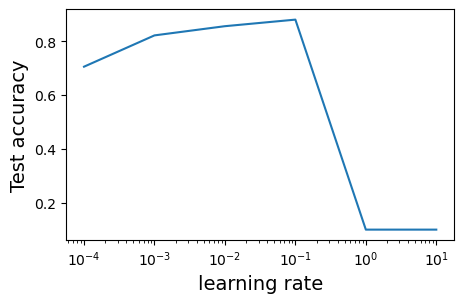

In [46]:
# plot graph lrate vs test accuracy
if training==True:
    fig, ax = plt.subplots(1,1, sharey=True, figsize=(5,3))
    
    ax.plot(lrates, test_acc)
    plt.xlabel("learning rate", fontsize=14)
    plt.ylabel("Test accuracy", fontsize=14)
    plt.xscale('log')   
    plt.show()

In [79]:
# This cell is for tests


In [80]:
# This cell is for tests

# for reproducibility
keras.utils.set_random_seed(0)


### Analyze learning curves.

During training, we always evaluate loss (and accuracy) on two datasets - training and validation. Why do we need a validation dataset? The training loss (and accuracy) is a poor estimate of a model's performance because it is calculated on the same dataset that was used to train the model. The training dataset only represents a small sample of all available data points, this model will likely fit this subset very well, but fail to generalize to data points outside of the training set. This is especially a problem for big networks trained on small datasets. The validation set allows a more "fair" estimation of model performance, as it is not used for tuning the model's parameters.

Although overfitting is a much more common problem for deep networks, let's create some examples of underfitting and overfitting. Underfitting may happen, for example, if the network is too simple for a given problem (too few layers/ units in layers), thus lacking the capacity to learn useful representation from data.

**Underfitting**. Here we will make a model with only one hidden layer with 2 units. This will create a "bottleneck" architecture. Such kind of model will be able to fit well neither training nor validation sets.

In [49]:
model_under = keras.Sequential([
    layers.Dense(2, activation='relu',input_shape=(784,)),
    layers.Dense(10, activation='softmax')
])

**Optimal**. Here we will create a model with one hidden layer with 32 units. It is rather simple model, but sufficient in the case of FMNIST dataset.

In [50]:
model_opt = keras.Sequential([
    layers.Dense(32, activation='relu',input_shape=(784,)),
    layers.Dense(10, activation='softmax')
])

**Overfitting**. Here we will create a model with several hidden layer and many units. This should be enough to overfit on training set.

In [51]:
model_over = keras.Sequential([
    layers.Dense(256, activation='relu',input_shape=(784,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

Now, let's compile and train all three models and store results in a list `history_log`.

In [52]:
%%time

models = [model_under, model_opt, model_over]
history_log = []

if training==True:
    for model in models:
        model.compile(optimizer='RMSprop',
              loss='sparse_categorical_crossentropy',
              metrics='sparse_categorical_accuracy')

        history = model.fit(X_trainval, y_trainval, validation_split=0.2, batch_size=32, epochs=20, verbose=0)
        history_log.append(history)

CPU times: user 7min 25s, sys: 1min 16s, total: 8min 42s
Wall time: 2min 50s


Plot training and validation losses for all models:

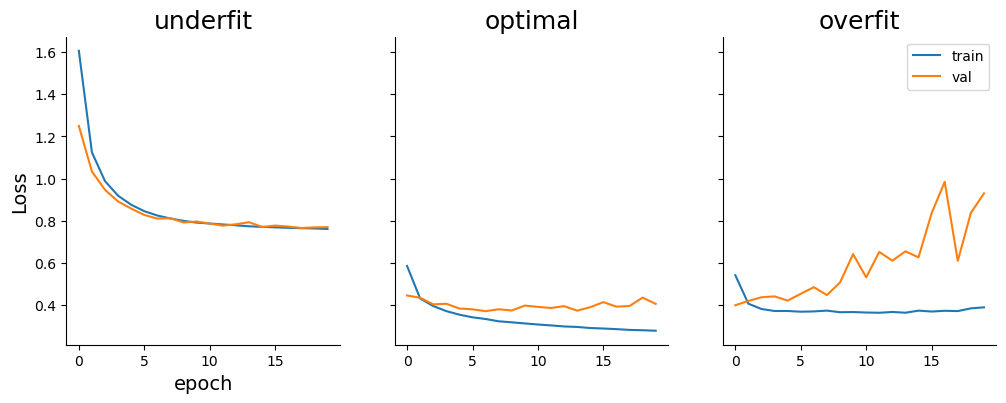

In [53]:
if training==True:
    fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,4))
    title = ["underfit", "optimal", "overfit"]

    for i in range(len(history_log)):
        ax[i].plot(history_log[i].history['loss'])
        ax[i].plot(history_log[i].history['val_loss'])
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].set_title(title[i], fontsize=18)

    ax[0].set_xlabel('epoch', fontsize=14)
    ax[0].set_ylabel('Loss', fontsize=14)

    plt.legend(['train', 'val'])
    plt.show()

As you can see, when the model underfits, it performs poorly on training and validation sets. In contrast, when the model overfits, the training loss is much smaller than the validation loss. The ideal situation is when training loss is low and slightly better than validation loss.

In [81]:
# Sanity checks
# check that regression model is trained and saved correctly

try:
    model_reg = tf.keras.models.load_model('model_reg.h5')
except:
    print('model_reg.h5' + " is not saved!")
else:
    print('model_reg.h5'+ " is saved.")
    test_loss = model_reg.evaluate(X_reg_test,y_reg_test, batch_size=128, verbose=0)
    if test_loss <= 0.42:
        print("Test loss is OK.")
    else:
        print("Test loss is too large! Make sure you trained the model and saved it correctly!")

model_reg.h5 is saved.
Test loss is OK.


In [82]:
# Sanity checks
# check that classification models are trained and saved correctly

model_names = ['model_256.h5', 'model_4x64.h5']

for model_name in model_names:
    try:
        model = tf.keras.models.load_model(model_name)
    except:
        print(model_name + " is not saved!")
    else:
        print(model_name + " is saved.")
        _, test_accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
        if test_accuracy >= 0.83:
            print("Test accuracy is OK.")
        else:
            print("Test accuracy is too large! Make sure you trained the model and saved it correctly!")

model_256.h5 is saved.
Test accuracy is OK.
model_4x64.h5 is saved.
Test accuracy is OK.


## Quiz 

Points: 0.25p per Question

<div class=" alert alert-success">
     <h3><b>Question 1.1.</b></h3>

Which of the following statements is correct?

1. An ANN is a network-like representation of non-linear maps between features and predicted label value

2. We typically adjust (learn) the ANN parameters (weights and bias terms) by random search 

3. ANNs can only be used to predict numeric label values (regression tasks)

4. ANNs that use only linear activation functions can still result overall in a non-linear map 
    
</div>

In [84]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE

answer_11  = 1

In [85]:
# This cell is for tests
assert answer_11 in [1,2,3,4], '"answer" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


Sanity check tests passed!


<div class=" alert alert-success">
     <h3><b>Question 1.2.</b></h3>

Choose the correct statement:

1. Every ANN with less than three hidden layers always represents a linear map between input features and output (predicted label)

2. To obtain non-linear maps between input and output, ANNs must use neurons with non-linear activation functions

3. ANNs with non-linear activation functions can only be used to predict numeric labels (regression tasks)
    
</div>

In [86]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE
answer_12  = 2

In [87]:
# This cell is for tests
assert answer_12 in [1,2,3], '"answer" Value should be an integer between 1 and 3.'
print('Sanity check tests passed!')


Sanity check tests passed!


<div class=" alert alert-success">
     <h3><b>Question 1.3.</b></h3>

Choose the correct statement:


1. The softmax activation function is typically used in the output layer of an ANN applied to a multi-class classification task

2. The softmax activation function is a popular choice for the output layer of an ANN applied to a regression task (numeric label values)

3. The ReLU activation function is often used in the output layer of an ANN applied to a binary classification task

4. The ReLU activation function is often used in the output layer of an ANN applied to a multi-class classification task



    
</div>

In [88]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE


answer_13  = 1

In [89]:
# This cell is for tests
assert answer_13 in [1,2,3,4], '"answer" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


Sanity check tests passed!


<div class="alert alert-success">
     <h3><b>Question 1.4.</b></h3>

Consider the following model:
    

```python     
model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(784,)),  # hidden layer 1
        layers.Dense(128, activation='softmax')                    # hidden layer 2
    ])
```


What is the input shape of the hidden layer 2?
         
1. input_shape = (784,)
2. input_shape = (256,)
3. input_shape = (128,)
4. input_shape = (1,)

</div>

In [90]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE
answer_14  = 3

In [91]:
# This cell is for tests
assert answer_14 in [1,2,3,4], '"answer" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


Sanity check tests passed!
